In [1]:
import sqlite3
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
sns.set_style('white')
sns.set_context('notebook')


conn = sqlite3.connect('knwlg_blf.db')
dat = pd.read_sql('SELECT * FROM trials A INNER JOIN subjects B ON A.prolific_id = B.prolific_id WHERE B.completion_code="548DA3BD"', con=conn)
dat = dat.loc[:,~dat.columns.duplicated()].copy() # prolific id from both tables will be in df, remove duplicate
# REMOVE DISTRACTORS
dat = dat.loc[dat.trial_type == 'test'].reset_index(drop=True)

# Cleaning.
## Make sure correct answer key is accurate

In [2]:
# fix correct answers
dat.loc[dat.belief_type == 'TB', 'correct_answer'] = 'j'
dat.loc[dat.belief_type != 'TB', 'correct_answer'] = 'f'
# update correct column based on new answer key
dat['response_key'] = dat.response_key.apply(literal_eval)
dat['correct'] = dat.apply(lambda row: row['response_key'][-1].lower() == row['correct_answer'], axis=1)
len(dat.prolific_id.unique())

501

### Exclude trials where subjects responded shortly after the 5-second times

In [3]:
# removing weird responses where more than one response and one of them is 999 (timeout)
# this should not be impossible because of the timer. Possibly my fault for not removing keypress event handler at 5 seconds.
# corrected after n=~250, shouldn't make much of a difference since these would be marked incorrect anyway.
weird_resps = dat.loc[(dat.response_key.apply(len)>1) & (dat.apply(lambda row: '999' in row['response_key'], axis=1))].index
dat.drop(weird_resps, inplace=True)
dat.shape

(5809, 26)

## Exclude participants with mean accuracy < .6

In [4]:
xx = dat.groupby('prolific_id').correct.mean() >.6
dat = dat.loc[dat.prolific_id.isin(xx[xx ==True].index.tolist())]

## Convert SQL strings to python datetime object and compute timedeltas

In [5]:
dat['response_onset'] = dat.apply(lambda row: datetime.datetime.strptime(row['response_onset'], '%Y-%m-%d %H:%M:%S.%f'), axis=1)
dat['target_onset'] = dat.apply(lambda row: datetime.datetime.strptime(row['target_onset'], '%Y-%m-%d %H:%M:%S.%f'), axis=1)
dat['rt'] = dat.apply(lambda row: row['response_onset'] - row['target_onset'], axis=1)
dat['rt_ms'] = dat.apply(lambda row: int(round(row['rt'].total_seconds() * 1e3)), axis=1)

## Check to make sure all responses came AFTER the target onset

In [6]:
sum(dat.apply(lambda row: row['response_onset'] > row['target_onset'], axis=1)) == len(dat)

True

## Exclude subjects with mean RTs less than 1500ms or more than 4000ms

In [7]:
xx = dat.groupby('prolific_id').rt_ms.mean() < 1500
dat = dat.loc[dat.prolific_id.isin(xx[xx == False].index.tolist())]
yy = dat.groupby('prolific_id').rt_ms.mean() > 4000
dat = dat.loc[dat.prolific_id.isin(yy[yy == False].index.tolist())]


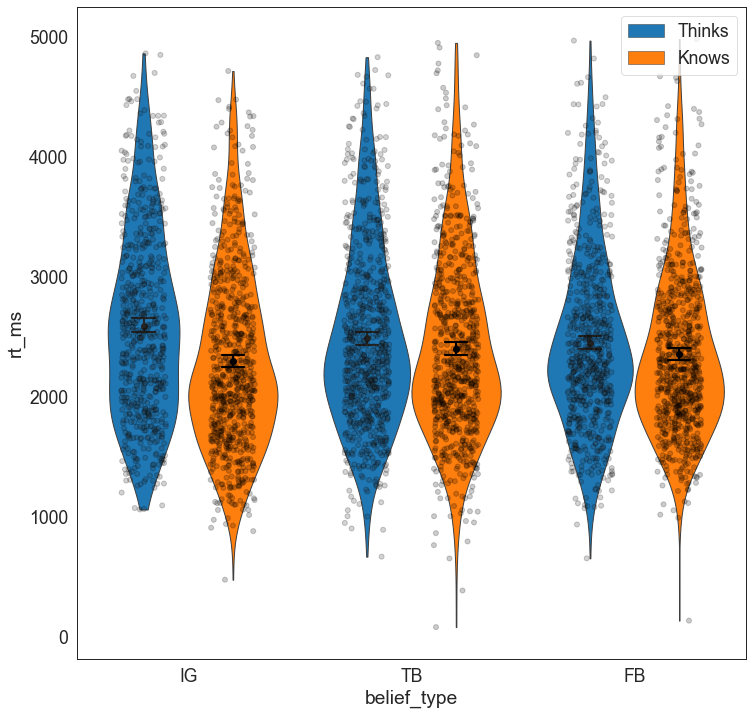

In [8]:
sns.set_context('paper', font_scale=2)
fig, ax = plt.subplots(figsize=(12,12))
g = sns.violinplot(x='belief_type', y='rt_ms', hue='ascription_type', data=dat.loc[(dat.trial_type=='test') & (dat.correct==True)], cut=0, bw=0.25, ax=ax, inner=None, linewidth=1, saturation=1)
g = sns.stripplot(x='belief_type', y='rt_ms', hue='ascription_type', data=dat.loc[(dat.trial_type=='test') & (dat.correct==True)],
                  color='k', dodge=True, ax=ax, jitter=.2, linewidth=1, alpha=.2)
g= sns.pointplot(x='belief_type', y='rt_ms', hue='ascription_type', data=dat.loc[(dat.trial_type=='test') & (dat.correct==True)], join=False, dodge=.4, capsize=.1, ax=ax, color='k',)

ax.legend(g.get_legend_handles_labels()[0][:2], g.get_legend_handles_labels()[1][:2])

#fig.savefig('control_rt.png')

In [9]:
len(dat.prolific_id.unique())

423

# Felicity Judgements

In [10]:
import sqlite3
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
sns.set_style('white')
sns.set_context('notebook')


conn = sqlite3.connect('knwlg_blf.db')
f_dat = pd.read_sql('SELECT * FROM felicities A INNER JOIN subjects B ON A.prolific_id = B.prolific_id WHERE B.completion_code="548DA3BD"', con=conn)
f_dat = f_dat.loc[:,~f_dat.columns.duplicated()].copy() # prolific id from both tables will be in df, remove duplicate

# 1= "Sounds very weird"
# 7 = "Sounds very normal"
f_dat['Infelicity Rating'] = 8 - f_dat.felicity_rating

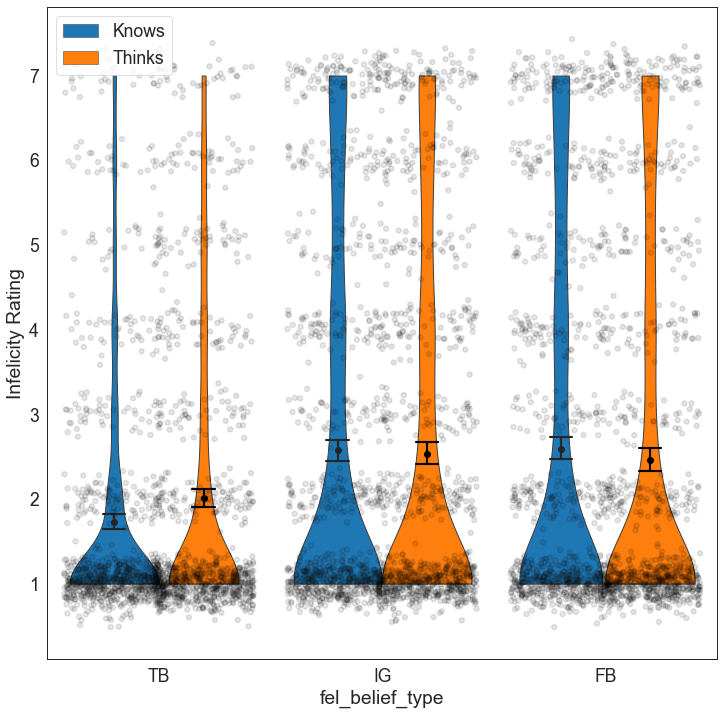

In [11]:
sns.set_context('paper', font_scale=2)
fig, ax = plt.subplots(figsize=(12,12))
g = sns.violinplot(x='fel_belief_type', y='Infelicity Rating', hue='fel_ascription_type', data=f_dat, cut=0, bw=0.25, ax=ax, inner=None, linewidth=1, saturation=1, order=['TB', 'IG', 'FB'])

def jitter(values,j):
    return values + np.random.normal(j,0.15,values.shape)

g = sns.stripplot(x='fel_belief_type', y=jitter(f_dat['Infelicity Rating'], 0), hue='fel_ascription_type', data=f_dat,
                  color='k', dodge=True, ax=ax, jitter=.45, linewidth=1.5, alpha=.1, order=['TB', 'IG', 'FB'])
g= sns.pointplot(x='fel_belief_type', y='Infelicity Rating', hue='fel_ascription_type', data=f_dat, join=False, dodge=.4, capsize=.1, ax=ax, color='k',order=['TB', 'IG', 'FB'])

ax.legend(g.get_legend_handles_labels()[0][:2], g.get_legend_handles_labels()[1][:2])

fig.savefig('control_fel.png')

In [12]:
len(f_dat.prolific_id.unique())

501

# Demographics

In [25]:
import sqlite3
import pandas as pd
import datetime
import seaborn as sns
from ast import literal_eval
sns.set_style('white')
sns.set_context('notebook')


conn = sqlite3.connect('knwlg_blf.db')
demos = pd.read_sql('SELECT * FROM demographics A INNER JOIN subjects B ON A.prolific_id = B.prolific_id WHERE B.completion_code="548DA3BD"', con=conn)
demos = demos.loc[:,~demos.columns.duplicated()].copy() # prolific id from both tables will be in df, remove duplicate

subjects = dat.prolific_id.unique()
demos = demos[demos.prolific_id.isin(subjects).values] # only use subjects in trial analysis
demos.education.describe()

count                          423
unique                           9
top       College Graduate(4 year)
freq                           157
Name: education, dtype: object

# AQ-10

In [17]:

import numpy as np

conn = sqlite3.connect('knwlg_blf.db')
a_dat = pd.read_sql('SELECT * FROM autism_scores A INNER JOIN subjects B ON A.prolific_id = B.prolific_id WHERE B.completion_code="548DA3BD"', con=conn)
a_dat = a_dat.loc[:,~a_dat.columns.duplicated()].copy() # prolific id from both tables will be in df, remove duplicate

a_dat = a_dat[a_dat.prolific_id.isin(dat.prolific_id.unique()).values] # only use subjects in trial analysis
a_dat.describe()

,id,AQ_rating_1,AQ_rating_2,AQ_rating_3,AQ_rating_4,AQ_rating_5,AQ_rating_6,AQ_rating_7,AQ_rating_8,AQ_rating_9,AQ_rating_10,block1_complete,block2_complete,block3_complete
count,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.0,423.0,423.0
mean,286.522459,2.836879,2.635934,2.513002,2.765957,3.023641,3.276596,1.836879,2.600473,2.919622,2.099291,1.0,1.0,1.0
std,162.608400,0.938569,0.859756,0.918063,0.925968,0.902555,0.841233,0.793553,0.965617,0.861591,0.842910,0.0,0.0,0.0
min,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0
25%,145.500000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,1.000000,2.000000,2.000000,2.000000,1.0,1.0,1.0
50%,282.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,3.000000,3.000000,2.000000,1.0,1.0,1.0
75%,423.500000,4.000000,3.000000,3.000000,3.000000,4.000000,4.000000,2.000000,3.000000,4.000000,3.000000,1.0,1.0,1.0
max,567.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,1.0,1.0,1.0


## scoring

In [75]:
## Scoring
agree = ['AQ_rating_1', 'AQ_rating_7', 'AQ_rating_8', 'AQ_rating_10'] # score of 3 or 4 get a point
disagree = ['AQ_rating_2','AQ_rating_3','AQ_rating_4','AQ_rating_5','AQ_rating_6','AQ_rating_9', ] # score of 1 or 2 get a point]
a = a_dat[agree] >= 3
b = a_dat[disagree] < 3
a_dat['AQ_score'] = a.sum(axis=1) + b.sum(axis=1)

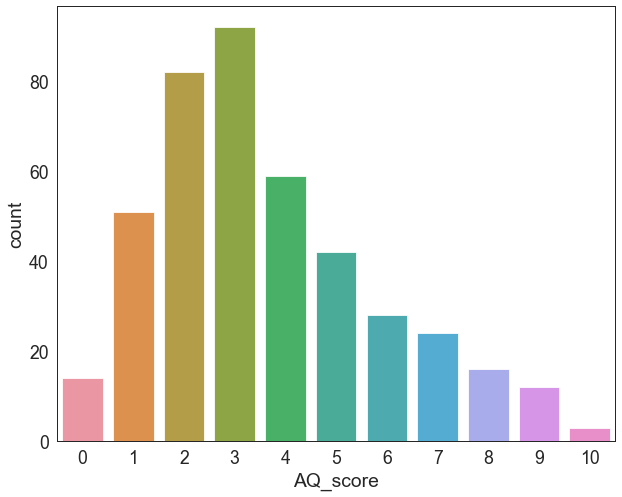

In [86]:

sns.set_context('paper', font_scale=2)
fg, ax = plt.subplots(figsize=(10, 8))
sns.countplot(data=a_dat, x='AQ_score', ax=ax)
plt.savefig('control_aq_score.png')

In [83]:
a_dat.groupby('AQ_score').count()

,id,AQ_rating_1,AQ_rating_2,AQ_rating_3,AQ_rating_4,AQ_rating_5,AQ_rating_6,AQ_rating_7,AQ_rating_8,AQ_rating_9,...,screen_width,screen_height,operating_sys,operating_sys_lang,GMT_timestamp,block1_complete,block2_complete,block3_complete,completion_code,feedback
AQ_score,,,,,,,,,,,,,,,,,,,,,
0,14,14,14,14,14,14,14,14,14,14,...,0,0,0,0,14,14,14,14,14,14
1,51,51,51,51,51,51,51,51,51,51,...,0,0,0,0,51,51,51,51,51,51
2,82,82,82,82,82,82,82,82,82,82,...,0,0,0,0,82,82,82,82,82,82
3,92,92,92,92,92,92,92,92,92,92,...,0,0,0,0,92,92,92,92,92,92
4,59,59,59,59,59,59,59,59,59,59,...,0,0,0,0,59,59,59,59,59,59
5,42,42,42,42,42,42,42,42,42,42,...,0,0,0,0,42,42,42,42,42,42
6,28,28,28,28,28,28,28,28,28,28,...,0,0,0,0,28,28,28,28,28,28
7,24,24,24,24,24,24,24,24,24,24,...,0,0,0,0,24,24,24,24,24,24
8,16,16,16,16,16,16,16,16,16,16,...,0,0,0,0,16,16,16,16,16,16


In [34]:
aa = a_dat.melt(id_vars= 'prolific_id', value_vars=a_dat.columns[1:11], var_name='AQ_item', value_name='rating')
for i, label in enumerate(a_dat.columns[1:11]):
    #new ="AQ_"+str(i+1)
    aa['AQ_item'] = aa['AQ_item'].str.replace(label,"AQ_"+str(i+1) )

In [35]:
aa

,prolific_id,AQ_item,rating
0,5f387a91c150681609c759f9,AQ_1,4
1,60c3aa01f9f6e994d8d7a273,AQ_1,3
2,5fb6f3bc48d534199270ad38,AQ_1,3
3,5f988a053b4bf5186a5d6693,AQ_1,3
4,62a39ad98ce3882e11e54d8f,AQ_1,4
...,...,...,...
4225,5c1942e200849900010afdcd,AQ_10,2
4226,60ddf4b3e6b47e907bd5e6b9,AQ_10,1
4227,61452bbe86c21c0347085911,AQ_10,1
4228,5dd9923922749791b319fc19,AQ_10,1


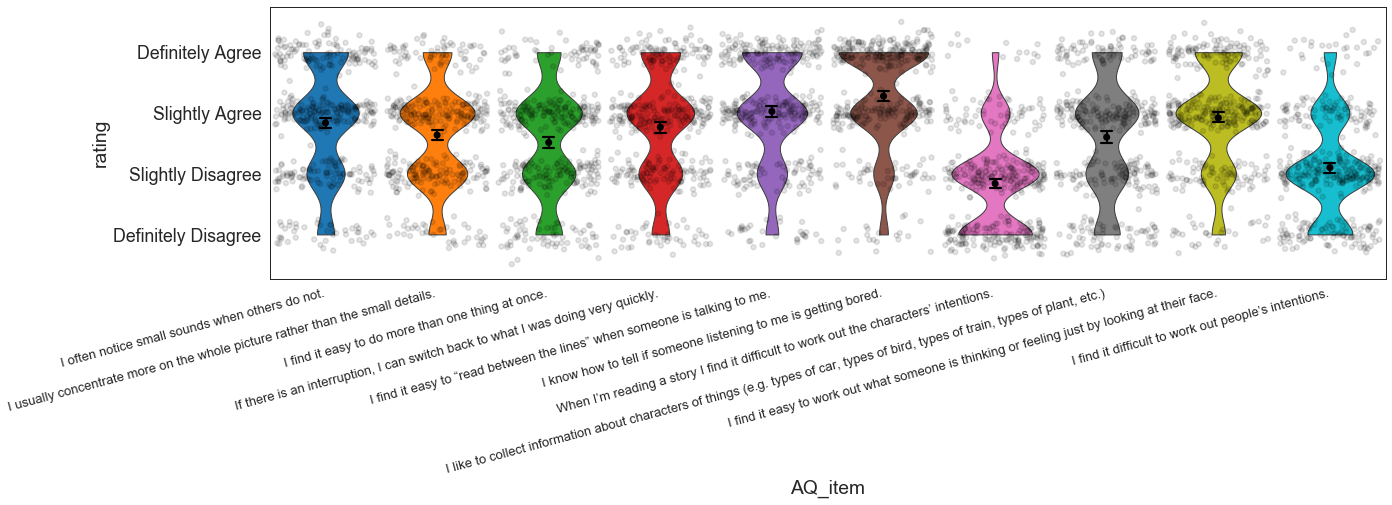

In [56]:
items = ["I often notice small sounds when others do not.",
                 "I usually concentrate more on the whole picture rather than the small details.",
                 "I find it easy to do more than one thing at once.",
                 "If there is an interruption, I can switch back to what I was doing very quickly.",
                 "I find it easy to “read between the lines” when someone is talking to me.",
                 "I know how to tell if someone listening to me is getting bored.",
                 "When I’m reading a story I find it difficult to work out the characters’ intentions.",
                 "I like to collect information about characters of things (e.g. types of car, types of bird, types of train, types of plant, etc.)",
                 "I find it easy to work out what someone is thinking or feeling just by looking at their face.",
                 "I find it difficult to work out people’s intentions."]


sns.set_context('paper', font_scale=2)
fig, ax = plt.subplots(figsize=(20,5))
g = sns.violinplot(x='AQ_item', y='rating', data=aa, cut=0, ax=ax, inner=None, linewidth=1, saturation=1)

def jitter(values,j):
    return values + np.random.normal(j,0.15,values.shape)

g = sns.stripplot(x='AQ_item', y=jitter(aa['rating'], 0), data=aa,
                  color='k', dodge=True, ax=ax, jitter=.45, linewidth=1.5, alpha=.1)

g= sns.pointplot(x='AQ_item', y='rating', data=aa, join=False, dodge=.4, capsize=.1, ax=ax, color='k',)
ax.set_yticklabels(['','Definitely Disagree', 'Slightly Disagree', 'Slightly Agree', 'Definitely Agree'])
ax.set_xticklabels(items, rotation=15, fontdict={'fontsize': 13,'horizontalalignment': 'right'})

#ax.legend(g.get_legend_handles_labels()[0][:2], g.get_legend_handles_labels()[1][:2])

fig.savefig('control_aq_10.png', bbox_inches='tight')

0      3
1      4
2      3
3      3
4      5
      ..
494    2
495    4
496    4
498    4
500    6
Length: 423, dtype: int64

In [74]:
a.sum(axis=1)

0      2
1      1
2      2
3      2
4      3
      ..
494    1
495    2
496    2
498    2
500    4
Length: 423, dtype: int64

In [72]:
b.sum(axis=1)

0      1
1      3
2      1
3      1
4      2
      ..
494    1
495    2
496    2
498    2
500    2
Length: 423, dtype: int64

In [62]:
a_dat[agree]

,AQ_rating_1,AQ_rating_7,AQ_rating_8,AQ_rating_10
0,4,1,3,2
1,3,2,2,2
2,3,1,3,2
3,3,2,3,2
4,4,2,4,3
...,...,...,...,...
494,2,2,3,2
495,3,1,3,1
496,4,1,3,1
498,4,1,4,1


# Statistics

In [13]:
from tqdm import tqdm

cols = ['prolific_id', 'scenario', 'ascription', 'belief', 'rt', 'felicity']
sdat = pd.DataFrame(columns=cols)
for subject in tqdm(list(dat.prolific_id.unique())):
   for scene in list(range(1,13)):
       t = dat.loc[(dat.prolific_id == subject) & (dat.scenario == int(scene))]
       f = f_dat.loc[(f_dat.prolific_id == subject) & (f_dat.fel_scenario == scene)]
       if len(t) == len(f) == 1:
        row_vals = [t.prolific_id.values[0], scene, t.ascription_type.values[0], t.belief_type.values[0], t.rt_ms.values[0], f['Infelicity Rating'].values[0]]
        sdat = sdat.append(pd.DataFrame([row_vals],columns=cols))


100%|██████████| 423/423 [00:58<00:00,  7.26it/s]


In [44]:
from pymer4 import Lmer

m1 = Lmer("rt ~ ascription + belief + felicity + (ascription + belief|prolific_id) + (1|scenario)", data=sdat)
m2 = Lmer("rt ~  belief + felicity + (ascription + belief|prolific_id) + (1|scenario)", data=sdat)
m1.fit(factors={"ascription":["Thinks", "Knows"], "belief":["TB", "FB", "IG"], "scenario":['1','2','3','4','5', '6', '7', '8', '9', '10', '11', '12']}, summarize=False)
m2.fit(factors={"ascription":["Thinks", "Knows"], "belief":["TB", "FB", "IG"], "scenario":['1','2','3','4','5', '6', '7', '8', '9', '10', '11', '12']}, summarize=False)
mc = Lmer.anova(m1, m2)
mc.iloc[:]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '


boundary (singular) fit: see ?isSingular 

SS Type III Analysis of Variance Table with Satterthwaite approximated degrees of freedom:
(NOTE: Model refit with orthogonal polynomial contrasts)


,SS,MS,NumDF,DenomDF,F-stat,P-val,Sig
ascription,4.752827e+07,4.752827e+07,1,229.216098,110.537350,2.358814e-21,***
belief,1.286319e+06,6.431597e+05,2,389.536086,1.495808,2.253516e-01,
felicity,3.981866e+05,3.981866e+05,1,3632.777690,0.926070,3.359503e-01,
